In [1]:
import chess
import chess.pgn
import requests
import os
from io import StringIO
from tqdm import tqdm
from IPython.display import display, clear_output
from time import sleep
from stockfish import Stockfish
import pandas as pd

In [2]:
os.chdir('..')

In [3]:
fish_path = 'stockfish-windows-x86-64-avx2/stockfish/stockfish-windows-x86-64-avx2.exe'

In [4]:
board = chess.Board()
hash_n = 32768
threads_n = 4
pv_n = 1
depth_n = 16
params_dict = {"Hash": hash_n, "Threads": threads_n}
starting_fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"

In [5]:
stockfish = Stockfish(path=fish_path, depth=depth_n, parameters=params_dict)

In [6]:
def get_reactive_move(cur_fen, enemy_loc):
    easy_moves = []
    board.set_fen(cur_fen)
    for move in board.legal_moves:
        move_to = move.to_square
        board.push(move)
        capture = (enemy_loc == move.to_square)
        threat = (enemy_loc in list(board.attacks(move_to)))
        if capture or threat:
            easy_moves.append(move)
        board.pop()
    return [move.uci() for move in easy_moves]

def get_forcing_move(cur_fen):
    forcing_moves = []
    board.set_fen(cur_fen)
    for move in board.legal_moves:
        capture = board.is_capture(move)
        board.push(move)
        check = board.is_check()
        if check or capture:
            forcing_moves.append(move)
        board.pop()
    return [move.uci() for move in forcing_moves]

In [7]:
def view_game(moves, animate=True):
    rows = []
    current_moves = []
    stockfish.set_fen_position(starting_fen)
    board.reset()
    ply = 1
    previous_square = None
    for move in tqdm(moves, desc="Processing moves", unit="move", leave=True):
        row = {}
        uci_move = chess.Move.from_uci(move)
        row['move_number'] = (ply+1)//2
        row['ply_number'] = ply
        row['notation'] = board.san(uci_move)
        row['move'] = move
        row['legal_moves'] = board.legal_moves.count()
        row['best_moves'] = stockfish.get_top_moves(3)
        row['react_moves'] = get_reactive_move(board.fen(), previous_square)
        row['forcing_moves'] = get_forcing_move(board.fen())

        current_moves.append(move)
        stockfish.set_position(current_moves)
        
        board.push(uci_move)
        previous_square = uci_move.to_square
        rows.append(row)
        ply += 1
        
        if animate:
            clear_output(wait=True)
            display(board)
    
    return rows

In [8]:
def get_most_recent_game(username):
    url = f'https://api.chess.com/pub/player/{username}/games/archives'
    headers = {'User-Agent': f'MyChessApp (contact: gencharleslee@gmail.com; username: Charles1ee)'}
    response = requests.get(url, headers=headers)

    url_with_month = response.json()['archives'][-1]
    response_with_month = requests.get(url_with_month, headers=headers)

    if response_with_month.status_code == 200:
        games = response_with_month.json()
        
        if games['games']:
            most_recent_game = games['games'][-4]['pgn']
            return most_recent_game

print(get_most_recent_game('Charles1ee'))

[Event "Live Chess"]
[Site "Chess.com"]
[Date "2023.12.19"]
[Round "-"]
[White "DamFluDatShotim"]
[Black "Charles1ee"]
[Result "0-1"]
[CurrentPosition "6Q1/5p2/3k4/1p5K/5P2/8/8/7r w - -"]
[Timezone "UTC"]
[ECO "B02"]
[ECOUrl "https://www.chess.com/openings/Alekhines-Defense-Scandinavian-Variation-3.exd5"]
[UTCDate "2023.12.19"]
[UTCTime "15:22:06"]
[WhiteElo "1464"]
[BlackElo "1334"]
[TimeControl "900+10"]
[Termination "Charles1ee won by resignation"]
[StartTime "15:22:06"]
[EndDate "2023.12.19"]
[EndTime "15:53:44"]
[Link "https://www.chess.com/game/live/96738139243"]

1. e4 {[%clk 0:15:10]} 1... d5 {[%clk 0:15:10]} 2. exd5 {[%clk 0:15:18.1]} 2... Nf6 {[%clk 0:15:19]} 3. Nc3 {[%clk 0:15:28]} 3... Nxd5 {[%clk 0:15:27.4]} 4. Nf3 {[%clk 0:14:22.5]} 4... Nxc3 {[%clk 0:15:32.6]} 5. bxc3 {[%clk 0:14:31.5]} 5... Bf5 {[%clk 0:15:28.1]} 6. Bc4 {[%clk 0:13:28.7]} 6... e6 {[%clk 0:15:36.5]} 7. d4 {[%clk 0:12:56]} 7... c5 {[%clk 0:15:45.3]} 8. d5 {[%clk 0:12:41.2]} 8... exd5 {[%clk 0:15:31.8]} 9.

In [10]:
pgn = get_most_recent_game('Charles1ee')
file_path = 'asset/last_game.pgn'

with open(file_path, 'w') as file:
    file.write(pgn)
    
pgn = StringIO(pgn)
game = chess.pgn.read_game(pgn)
moves = [x.uci() for x in game.mainline_moves()]
#print(game.headers.__dict__)
#print([x.uci() for x in game.mainline_moves()])

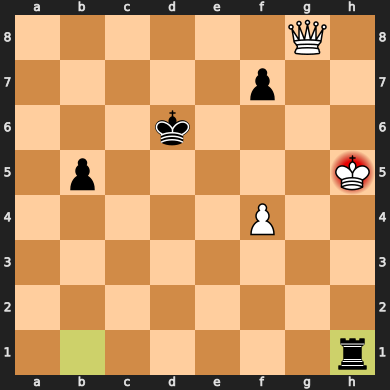


Processing moves: 100%|██████████████████████████████████████████████████████████████| 94/94 [04:33<00:00,  2.91s/move]


,move_number,ply_number,notation,move,legal_moves,best_moves,react_moves,forcing_moves
0,1,1,e4,e2e4,20,"[{'Move': 'e2e4', 'Centipawn': 39, 'Mate': Non...",[],[]
1,1,2,d5,d7d5,20,"[{'Move': 'e7e5', 'Centipawn': 22, 'Mate': Non...","[g8f6, f7f5, d7d5]",[]
2,2,3,exd5,e4d5,31,"[{'Move': 'e4d5', 'Centipawn': 61, 'Mate': Non...","[f1c4, d1h5, b1c3, e4d5, c2c4]","[f1b5, e4d5]"
3,2,4,Nf6,g8f6,28,"[{'Move': 'g8f6', 'Centipawn': 69, 'Mate': Non...","[g8f6, d8d7, d8d6, d8d5, c8e6, e7e6, c7c6]",[d8d5]
4,3,5,Nc3,b1c3,30,"[{'Move': 'g1f3', 'Centipawn': 77, 'Mate': Non...",[d1f3],[f1b5]
...,...,...,...,...,...,...,...,...
89,45,90,Rxb4,e4b4,21,"[{'Move': 'e4b4', 'Centipawn': -725, 'Mate': N...","[e4e6, g7h6]","[e4e5, e4f4, e4b4, g7h6, g7g6]"
90,46,91,hxg7,h6g7,6,"[{'Move': 'h6g7', 'Centipawn': -771, 'Mate': N...",[],[h6g7]
91,46,92,Rb1,b4b1,17,"[{'Move': 'b4b1', 'Centipawn': -774, 'Mate': N...",[],[b4f4]
92,47,93,g8=Q,g7g8q,9,"[{'Move': 'h5g5', 'Centipawn': -792, 'Mate': N...",[],[]


In [11]:
the_game = view_game(tqdm(moves))
moves_df = pd.DataFrame(the_game)
moves_df